# Heartbeat Sensei: Detecting Arrhythmias with Deep Learning

## Problem Identification

Cardiovasculare diseases are among the leading causes of death worldwide.Detecting irregular heartbeats (arrhythmias) early can literally save lives.Traditionally,cardiologists rely on visual inspection of ECG recordings, a process that is time consuming,requires deep expertise, and can miss subtle patterns in noisy signals

## Goal

The aim of this project is to build an automatic heartbeat classification system that can learn to recognize different types of heartbeats from raw ECG signals. Specifically, the project uses the MIT-BIH Arrhythmia Database to train a 1D Convolutional Neural Network (CNN) that can classify beats into clinically meaningful categories following the AAMI standard.

## Loading the data

In [ ]:
import wfdb
import numpy as np
import pandas as pd
from pathlib import Path
import os, glob
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras import Sequential, layers
from tensorflow.keras import metrics as km
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, f1_score, classification_report
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, regularizers as reg, optimizers as opt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score





## Creating the dataframe (MIT-BIH Data Preprocessing)

###  Reading the ECG Records

- In order to fully understand the various tables within the dataset, the first step here is to understand the data and how it is distributed. The main goal in this section is to create one unifying Dataframe with the columns of interest / features that are going to enable us make our predictions with the models. 

###  Why this dataset is adaptable


The structure of the dataset allows it to be framed in different supervised learning tasks:

1. **Binary Classification (CNN-ready)**  
   - Target: Detect specific abnormal beats (e.g., PVC vs. non-PVC).  
   - Features: Short waveform snippets around each beat (216 samples, single lead or both leads).  
   - Task: Train a **1D CNN** to recognize local beat morphology.

2. **Multi-Class Classification (CNN-ready)**  
   - Target: Classify beats into one of the **AAMI 5 categories (N, S, V, F, Q)**.  
   - Features: Same waveform snippets, with optional use of both leads.  
   - Task: Train a **1D CNN** to distinguish between multiple arrhythmia types.  

3. **Sequence Modeling (LSTM-ready)**  
   - Target: Predict the type of a beat based on the context of previous beats, or classify rhythm patterns over time (e.g., AFib, bigeminy).  
   - Features: Beat sequences (waveform snippets + RR intervals).  
   - Task: Train an **LSTM** (or hybrid CNN+LSTM) to capture temporal dependencies and rhythm irregularities.


In [2]:
DATA_DIR = "/Users/turfdiddy/Desktop/Bootcamp_ds:ml/Week_7/Project_heart_sensei/mit-bih-arrhythmia-database-1.0.0/x_mitdb"


In [3]:
RECORDS = [
    100,101,102,103,104,105,106,107,108,109,
    111,112,113,114,115,116,117,118,119,121,122,123,124,
    200,201,202,203,205,207,208,209,210,212,213,214,215,
    217,219,220,221,222,223,228,230,231,232,233,234
]

In [4]:
# 1) Read available record names from the RECORDS file (most robust)
with open(os.path.join(DATA_DIR, "RECORDS")) as f:
    RECORDS = [line.strip() for line in f if line.strip() and not line.startswith("#")]

print("Found records:", RECORDS[:10])  # should look like ['x_100','x_101',...]


Found records: ['x_108', 'x_109', 'x_111', 'x_112', 'x_113', 'x_114', 'x_115', 'x_116', 'x_117', 'x_121']


In [5]:
rec = RECORDS[0]
print("Using record:", rec)



Using record: x_108


In [6]:
os.chdir(DATA_DIR)
record = wfdb.rdrecord(rec)          # auto-reads rec.hea + rec.dat in CWD
ann    = wfdb.rdann(rec, "atr")      # reads rec.atr

print("Signal shape:", record.p_signal.shape)  # (samples, 2)
print("fs:", record.fs)
print("First ann symbols:", ann.symbol[:10])

Signal shape: (216000, 2)
fs: 360
First ann symbols: ['+', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']


In [7]:
# Read actual record names from the RECORDS file (handles x_ prefix automatically)
with open(os.path.join(DATA_DIR, "RECORDS")) as f:
    RECORDS = [line.strip() for line in f if line.strip() and not line.startswith("#")]

# Work inside the folder so wfdb finds files easily
os.chdir(DATA_DIR)
print("Records found:", len(RECORDS), RECORDS[:10])

Records found: 23 ['x_108', 'x_109', 'x_111', 'x_112', 'x_113', 'x_114', 'x_115', 'x_116', 'x_117', 'x_121']


In [8]:
# AAMI mapping (others → 'Q')
AAMI_MAP = {
    # Normal & related
    'N':'N','L':'N','R':'N','e':'N','j':'N','·':'N',
    # Supraventricular
    'A':'S','a':'S','J':'S','S':'S',
    # Ventricular
    'V':'V','E':'V',
    # Fusion
    'F':'F',
}

# Keep only beat symbols (drop control markers like '+', rhythm labels, etc.)
VALID_BEAT_SYMBOLS = {
    'N','L','R','e','j','·','A','a','J','S','V','E','F','/','f','Q','|'
}

def aami(sym):  # map to AAMI 5 classes
    return AAMI_MAP.get(sym, 'Q')

In [9]:
rows = []
for rec in RECORDS:
    rec_hdr = wfdb.rdrecord(rec)
    fs = float(rec_hdr.fs)

    ann = wfdb.rdann(rec, "atr")
    times = ann.sample / fs

    for i, s in enumerate(ann.sample):
        sym = ann.symbol[i]
        if sym in VALID_BEAT_SYMBOLS:
            rows.append({
                "record": rec,
                "beat_idx": i,
                "sample_index": int(s),
                "time_sec": float(times[i]),
                "symbol": sym,
                "aami_class": aami(sym),
                "fs": fs,
            })

df = pd.DataFrame(rows).sort_values(["record","time_sec"]).reset_index(drop=True)
print(df.head(), df.shape)

  record  beat_idx  sample_index  time_sec symbol aami_class     fs
0  x_108         1            88  0.244444      N          N  360.0
1  x_108         2           442  1.227778      N          N  360.0
2  x_108         3           789  2.191667      N          N  360.0
3  x_108         4          1155  3.208333      N          N  360.0
4  x_108         5          1493  4.147222      N          N  360.0 (16132, 7)


In [10]:
# Binary PVC
df["is_pvc"] = (df["symbol"] == "V").astype(int)

# Binary Normal vs abnormal (optional)
df["is_normal"] = (df["aami_class"] == "N").astype(int)

# Multi-class AAMI (N,S,V,F,Q)
df["target_aami"] = df["aami_class"]

df["target_aami"].value_counts()

target_aami
N    14766
V      762
S      552
Q       30
F       22
Name: count, dtype: int64

In [11]:
# RR_prev (sec) and RR_next (sec)
df["rr_prev"] = df.groupby("record")["time_sec"].diff()          # t - t-1
df["rr_next"] = -df.groupby("record")["time_sec"].diff(-1)       # t+1 - t
df["rr_prev"] = df["rr_prev"].astype(np.float32).fillna(np.nan)
df["rr_next"] = df["rr_next"].astype(np.float32).fillna(np.nan)

In [12]:
PRE_S, POST_S = 0.20, 0.40

def zscore(x, eps=1e-8):
    mu = x.mean(axis=0, keepdims=True)
    sd = x.std(axis=0, keepdims=True) + eps
    return (x - mu)/sd

def extract_snippet(sig_z, center_idx, fs, pre_s=PRE_S, post_s=POST_S):
    pre_n  = int(round(pre_s * fs))
    post_n = int(round(post_s * fs))
    start  = center_idx - pre_n
    end    = center_idx + post_n
    # pad with edge values if needed
    if start < 0:
        pad = np.repeat(sig_z[[0], :], -start, axis=0)
        snip = np.vstack([pad, sig_z[:end, :]])
    elif end > sig_z.shape[0]:
        pad = np.repeat(sig_z[[-1], :], end - sig_z.shape[0], axis=0)
        snip = np.vstack([sig_z[start:, :], pad])
    else:
        snip = sig_z[start:end, :]
    # enforce fixed length
    win_len = pre_n + post_n
    if snip.shape[0] != win_len:
        # crop or pad (edge)
        if snip.shape[0] > win_len:
            snip = snip[:win_len]
        else:
            pad = np.repeat(snip[[-1], :], win_len - snip.shape[0], axis=0)
            snip = np.vstack([snip, pad])
    return snip.astype(np.float32)

snippets = []
last_rec = None
sig_z = None

for i, row in df.iterrows():
    rec = row["record"]
    if rec != last_rec:
        rec_hdr = wfdb.rdrecord(rec)
        sig = rec_hdr.p_signal.astype(np.float32)  # (T, 2)
        sig_z = zscore(sig)                        # per-record z-score
        fs = float(rec_hdr.fs)
        last_rec = rec

    snip = extract_snippet(sig_z, row["sample_index"], fs)
    # store leads separately (makes stacking easy)
    snippets.append((snip[:,0], snip[:,1]))

lead1 = [s[0] for s in snippets]
lead2 = [s[1] for s in snippets]

df["snippet_lead1"] = lead1   # each is a vector length 216
df["snippet_lead2"] = lead2
df["win_len"] = len(df["snippet_lead1"].iloc[0])
print(df[["record","symbol","is_pvc","target_aami","rr_prev","rr_next","win_len"]].head())

  record symbol  is_pvc target_aami   rr_prev   rr_next  win_len
0  x_108      N       0           N       NaN  0.983333      216
1  x_108      N       0           N  0.983333  0.963889      216
2  x_108      N       0           N  0.963889  1.016667      216
3  x_108      N       0           N  1.016667  0.938889      216
4  x_108      N       0           N  0.938889  0.911111      216


In the next step we are saving our processed DataFrames in **Parquet format** instead of CSV because:

- **Efficiency**: Parquet is a compressed, binary format → smaller files and faster read/write.  
- **Columnar storage**: Makes it quicker to load only specific columns when needed.  
- **Type preservation**: Unlike CSV, Parquet keeps native data types (floats, ints, arrays).  
- **Handles complex objects**: Our ECG snippets are stored as arrays; CSV cannot store them cleanly.  

 This makes Parquet a better choice for machine learning pipelines where datasets are reloaded frequently.

In [13]:
# Master (everything)
df.to_parquet("mitbih_beats_master.parquet")

# PVC binary (drop Q if you want a super clean task)
df_pvc = df.copy()
df_pvc.to_parquet("mitbih_pvc_binary.parquet")

# AAMI 5-class (keep all N,S,V,F,Q)
df_aami5 = df.copy()
df_aami5.to_parquet("mitbih_aami5_multiclass.parquet")

print("Saved parquet files.")

Saved parquet files.


## PVC Binary Classification

### CNN Model v1  

#### Objective

The objective of the **binary classification CNN model** is to:

- **Input:** A fixed-length ECG waveform snippet (0.2s before and 0.4s after each beat).  

- **Output:** Predict whether the beat is a **Premature Ventricular Contraction (PVC)** or a **normal/non-PVC beat**.  

- **Problem type:** Supervised learning → **binary classification** (label `is_pvc`, where 1 = PVC, 0 = non-PVC).  

- **Goal:** Train a **1D Convolutional Neural Network** to automatically recognize abnormal PVC morphology in the ECG waveform.  


#### Why this is important

- PVC detection is a **clinically meaningful** first task: PVCs are common arrhythmias and can indicate heart stress if frequent.  

- It’s also a **machine learning baseline**: 

  - Simple, clear target (PVC vs non-PVC).  

  - Lets us test CNNs on waveform morphology.  
  
  - Sets the foundation before moving to multi-class or LSTM sequence tasks.

#### X , y train test split

-   This dataset consists of ECG signals


```text
                 ┌─────────────┐
                 │   Dataset   │
                 └──────┬──────┘
                        │
        ┌───────────────┴───────────────┐
        │                               │
 Independent samples?              Linked by entity/time?
 (e.g., CIFAR-10 images)           (e.g., ECG, vibration, stock prices)
        │                               │
        ▼                               ▼
 Row-wise split is fine           ┌──────────────┬──────────────┐
 (e.g., train_test_split)         │              │              │
                                  ▼              ▼              ▼
                          Entity-based split   Time-based split Other domain rules
                          (patients, machines) (train = past,   (depends on context:
                          e.g., MIT-BIH, CWRU)  test = future)   groups, sessions, etc.)

#### Why Entity-Based Splitting?

This dataset consists of **ECG signals** recorded from different patients.  
If I randomly split individual beats into train and test sets, the **same patient’s signals** could appear in both.  
That would cause **data leakage**, because the model might memorize patient-specific patterns instead of truly learning to detect arrhythmias.

 To avoid this, I used **entity-based splitting**:  
- The entity here is the **patient record**.  
- Each split (train/val/test) contains beats from **different patients**.  

This ensures the model is evaluated on **completely unseen patients**, giving a more realistic measure of how it would perform in practice.

In [14]:
df_pvc = pd.read_parquet("mitbih_pvc_binary.parquet")
print(df_pvc.head())
print(df_pvc["is_pvc"].value_counts())

  record  beat_idx  sample_index  time_sec symbol aami_class     fs  is_pvc  \
0  x_108         1            88  0.244444      N          N  360.0       0   
1  x_108         2           442  1.227778      N          N  360.0       0   
2  x_108         3           789  2.191667      N          N  360.0       0   
3  x_108         4          1155  3.208333      N          N  360.0       0   
4  x_108         5          1493  4.147222      N          N  360.0       0   

   is_normal target_aami   rr_prev   rr_next  \
0          1           N       NaN  0.983333   
1          1           N  0.983333  0.963889   
2          1           N  0.963889  1.016667   
3          1           N  1.016667  0.938889   
4          1           N  0.938889  0.911111   

                                       snippet_lead1  \
0  [0.02001411, -0.12258925, -0.24142274, -0.3127...   
1  [0.5666577, 0.44782194, 0.30521858, 0.21015042...   
2  [1.0419985, 0.8993951, 0.7092588, 0.5191225, 0...   
3  [0.020014

In [15]:

# Get unique patient records
records_all = sorted(df_pvc["record"].unique())

# Split by record (patient-wise)
train_recs, test_recs = train_test_split(records_all, test_size=0.2, random_state=42)
train_recs, val_recs  = train_test_split(train_recs, test_size=0.2, random_state=42)

print("Train records:", len(train_recs))
print("Val records:", len(val_recs))
print("Test records:", len(test_recs))

# Helper to subset
def by_split(dfx, recs):
    return dfx[dfx["record"].isin(recs)].reset_index(drop=True)

train_df = by_split(df_pvc, train_recs)
val_df   = by_split(df_pvc, val_recs)
test_df  = by_split(df_pvc, test_recs)

# Save them for reuse
train_df.to_parquet("pvc_train.parquet")
val_df.to_parquet("pvc_val.parquet")
test_df.to_parquet("pvc_test.parquet")

print(train_df.shape, val_df.shape, test_df.shape)

Train records: 14
Val records: 4
Test records: 5
(10525, 15) (2468, 15) (3139, 15)


In [16]:

train_df = pd.read_parquet("pvc_train.parquet")
val_df   = pd.read_parquet("pvc_val.parquet")
test_df  = pd.read_parquet("pvc_test.parquet")

# 1) Leakage sanity check (no overlapping patients)
print(set(train_df.record) & set(val_df.record), set(train_df.record) & set(test_df.record), set(val_df.record) & set(test_df.record))

# 2) Class balance (PVCs are rare; note ratios)
print("Train PVC ratio:", train_df.is_pvc.mean())
print("Val PVC ratio:",   val_df.is_pvc.mean())
print("Test PVC ratio:",  test_df.is_pvc.mean())

# 3) Build CNN inputs (lead 1; add channel dim)
X_train = np.stack(train_df.snippet_lead1.to_numpy())[..., None]
X_val   = np.stack(val_df.snippet_lead1.to_numpy())[..., None]
X_test  = np.stack(test_df.snippet_lead1.to_numpy())[..., None]

y_train = train_df.is_pvc.to_numpy()
y_val   = val_df.is_pvc.to_numpy()
y_test  = test_df.is_pvc.to_numpy()

X_train.shape, y_train.shape

set() set() set()
Train PVC ratio: 0.053966745843230406
Val PVC ratio: 0.012965964343598054
Test PVC ratio: 0.05160879260911118


((10525, 216, 1), (10525,))

Insights:
-   All results are set() → empty intersections 
-   Meaning: no patient appears in more than one split which means data leakage was avoided

##### Checking Class Balance (PVC Ratios)

Before training, we checked how many beats in each split are **PVCs** vs **non-PVCs**.

- `is_pvc = 1` → beat is a PVC  
- `is_pvc = 0` → beat is not a PVC  
- Taking the **mean** of this column gives the **proportion of PVCs** in the dataset.

##### Results
- **Train set:** ~5.4% PVCs  
- **Validation set:** ~1.3% PVCs  
- **Test set:** ~5.2% PVCs  

##### Interpretation
- PVCs are **rare** compared to normal beats → the dataset is **highly imbalanced**.  
- A naive model predicting “always non-PVC” could reach ~95% accuracy, but would **fail to detect PVCs**.  
- This means:
  - We must use **class weights or sampling techniques** during training.  
  - We should evaluate using **Precision, Recall, and F1-score for PVC detection**, not just accuracy.

 The dataset imbalance makes PVC detection challenging, so our model must be carefully trained and evaluated to handle this.

#### Handling Imbalance with Class Weights


Since PVC beats are only ~5% of the dataset, we’ll use **class weights** to give them more importance during training.


In [17]:
classes = np.unique(y_train)   # [0, 1]
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

print("Class Weights:", class_weights)
# Example output: {0: 0.53, 1: 9.8}

Class Weights: {0: 0.5285226473837501, 1: 9.264964788732394}


Insights: 
-   That means the loss from a misclassified PVC is ~17.5× more costly than a misclassified non-PVC (9.265 / 0.529), nudging the model to actually learn PVCs instead of always predicting normal.

#### Model Build

In [19]:
model = Sequential([
    layers.Conv1D(32,5,activation="relu",input_shape=(216,1)),
    layers.MaxPooling1D(2),
    layers.Conv1D(64,5 , activation="relu"),
    layers.MaxPool1D(2),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1,activation="sigmoid")  #sigmoid was selected here because we have a binary classification
])


/opt/anaconda3/envs/tf310/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-31 19:39:46.437660: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-08-31 19:39:46.445938: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-08-31 19:39:46.446485: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-08-31 19:39:46.446803: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-08-31 19:39:46.447130: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:

In [20]:
import tensorflow as tf
print("TF:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))

TF: 2.16.1
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        km.Precision(name="precision"),
        km.Recall(name="recall"),
        km.AUC(name="auc_pr", curve="PR"),   # Precision-Recall AUC (great for imbalance)
        km.AUC(name="auc_roc", curve="ROC"),
    ]
)

#####  Why Metrics Must Be in a List (and Why They Matter Here)

When compiling a Keras model, the `metrics` argument must be passed as a **list or tuple**, not a plain string.  
This ensures Keras can track one or more evaluation metrics during training.

-  Wrong: `metrics="accuracy"` → just a string → error  
-  Correct: `metrics=["accuracy"]` → list format → works



#####  Why This Matters for the MIT-BIH PVC Dataset
- Our dataset is **highly imbalanced**: ~95% non-PVC beats vs. ~5% PVC beats.  
- If we only track **accuracy**, a model that predicts *all beats as normal* would still look ~95% “accurate” — but it would completely fail at detecting PVCs.  

By putting metrics in a list, we can add **multiple metrics** that are more meaningful for ECG classification:

- **Accuracy** → overall correctness (can be misleading here).  
- **Precision (PVC)** → of the beats the model predicted as PVC, how many were truly PVCs?  
- **Recall (PVC)** → of all the true PVCs in the data, how many did the model catch?  
- **AUC (ROC / PR)** → overall discriminative power; PR-AUC is especially useful for rare events like PVCs.  


 In summary: Using the list format for `metrics` not only fixed the technical error, but also allowed us to track **precision, recall, and AUC**, which are crucial for evaluating PVC detection on an imbalanced ECG dataset.

#### Model training using the Class weights

In [29]:
history = model.fit (
    X_train , y_train , 
    validation_data=(X_val , y_val),
    epochs=20,
    batch_size=64,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/20


2025-08-31 19:57:25.745105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


165/165 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.9061 - auc_pr: 0.7710 - auc_roc: 0.9641 - loss: 0.2936 - precision: 0.3540 - recall: 0.8961 - val_accuracy: 0.7435 - val_auc_pr: 0.0090 - val_auc_roc: 0.3364 - val_loss: 0.5284 - val_precision: 0.0017 - val_recall: 0.0312
Epoch 2/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9660 - auc_pr: 0.8675 - auc_roc: 0.9892 - loss: 0.1438 - precision: 0.6196 - recall: 0.9577 - val_accuracy: 0.6925 - val_auc_pr: 0.0096 - val_auc_roc: 0.3725 - val_loss: 1.0293 - val_precision: 0.0027 - val_recall: 0.0625
Epoch 3/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9698 - auc_pr: 0.8348 - auc_roc: 0.9882 - loss: 0.1615 - precision: 0.6467 - recall: 0.9701 - val_accuracy: 0.6921 - val_auc_pr: 0.0090 - val_auc_roc: 0.3546 - val_loss: 1.6172 - val_precision: 0.0014 - val_recall: 0.0312
Epoch 4/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9690 - auc_pr: 0.7672 - auc_roc: 0.9799 - loss: 0.4707 - precision: 0.6414 - 

Insights:

-   Train: acc 0.99, PR-AUC 0.91, recall 0.99 → the model learned to flag PVCs on training data (with class weights).

-   Val: acc 0.65, PR-AUC 0.02, precision 0.023, recall 0.625 → it’s predicting too many positives on a split where PVCs are ~1.3%, tanking precision.
(Baseline PR-AUC ≈ prevalence ≈ 0.013; your 0.020 is barely above baseline.)

Why this happens:
-   Class weights are pushing the model to catch rares → higher recall, but often very low precision on sparse validation.

-   Threshold 0.5 is arbitrary; with heavy class weighting, optimal thresholds shift.

-   Val split PVC-poor: a few false positives nuke precision/PR-AUC.


-   One way of addressing this could be to tune the decision threshold on the validation set by picking a threshold that maximizes F1 (or meets a specific recall /precision target)

In [31]:

val_scores = model.predict(X_val).ravel()
prec, rec, thr = precision_recall_curve(y_val, val_scores)

# Choose threshold that maximizes F1 on val
f1s = 2*(prec*rec)/(prec+rec + 1e-12)
best_idx = np.nanargmax(f1s)
best_thr = thr[best_idx]
print("Best thr:", best_thr, "F1:", f1s[best_idx], "P:", prec[best_idx], "R:", rec[best_idx])

# Apply on test
test_scores = model.predict(X_test).ravel()
y_pred = (test_scores >= best_thr).astype(int)
print(classification_report(y_test, y_pred, target_names=["Non-PVC","PVC"]))

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Best thr: 1.7789618e-09 F1: 0.05458089668609942 P: 0.028169014084507043 R: 0.875
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
              precision    recall  f1-score   support

     Non-PVC       1.00      0.54      0.70      2977
         PVC       0.10      0.98      0.19       162

    accuracy                           0.56      3139
   macro avg       0.55      0.76      0.45      3139
weighted avg       0.95      0.56      0.68      3139



In [32]:
from sklearn.metrics import precision_recall_curve

val_scores = model.predict(X_val).ravel()
prec, rec, thr = precision_recall_curve(y_val, val_scores)

# choose threshold with precision >= 0.5 and max recall
cand = [(P,R,T) for P,R,T in zip(prec,rec,thr) if P>=0.5]
bestP,bestR,bestT = max(cand, key=lambda x: x[1]) if cand else (prec[0], rec[0], thr[0])
print("Chosen thr:", bestT, "Precision:", bestP, "Recall:", bestR)

y_pred = (model.predict(X_test).ravel() >= bestT).astype(int)

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Chosen thr: 0.0 Precision: 0.012965964343598054 Recall: 1.0
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [33]:
class_weight = {0: 0.7, 1: 4.0}

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
cbs = [
  EarlyStopping(monitor="val_auc_pr", mode="max", patience=3, restore_best_weights=True),
  ModelCheckpoint("best_pvc_cnn.keras", monitor="val_auc_pr", mode="max", save_best_only=True),
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    class_weight=class_weight,
    callbacks=cbs,
    verbose=1
)

Epoch 1/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9950 - auc_pr: 0.9337 - auc_roc: 0.9938 - loss: 0.0872 - precision: 0.9228 - recall: 0.9894 - val_accuracy: 0.6536 - val_auc_pr: 0.0221 - val_auc_roc: 0.6794 - val_loss: 8.4814 - val_precision: 0.0265 - val_recall: 0.7188
Epoch 2/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9957 - auc_pr: 0.9410 - auc_roc: 0.9965 - loss: 0.0851 - precision: 0.9366 - recall: 0.9877 - val_accuracy: 0.6528 - val_auc_pr: 0.0195 - val_auc_roc: 0.6450 - val_loss: 5.6872 - val_precision: 0.0209 - val_recall: 0.5625
Epoch 3/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9948 - auc_pr: 0.9402 - auc_roc: 0.9965 - loss: 0.0645 - precision: 0.9198 - recall: 0.9894 - val_accuracy: 0.6483 - val_auc_pr: 0.0111 - val_auc_roc: 0.4647 - val_loss: 10.2138 - val_precision: 0.0094 - val_recall: 0.2500
Epoch 4/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9945 - auc_pr: 0.9264 - auc_roc: 0.9927 - loss: 0.1300 - precisio

In [35]:
mask = prec[:-1] >= 0.5                   # only where a threshold exists
if mask.any():
    cand_rec = rec[:-1][mask]
    cand_thr = thr[mask]
    best_thr = cand_thr[np.argmax(cand_rec)]
    print("Chosen thr:", best_thr)
else:
    # fallback: pick a high quantile to force precision up
    best_thr = np.quantile(val_scores, 0.995)
    print("No P>=0.5 point; using quantile thr:", best_thr)

No P>=0.5 point; using quantile thr: 1.0


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
0.0 1.0
[0.00000000e+00 3.91410021e-17 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00]


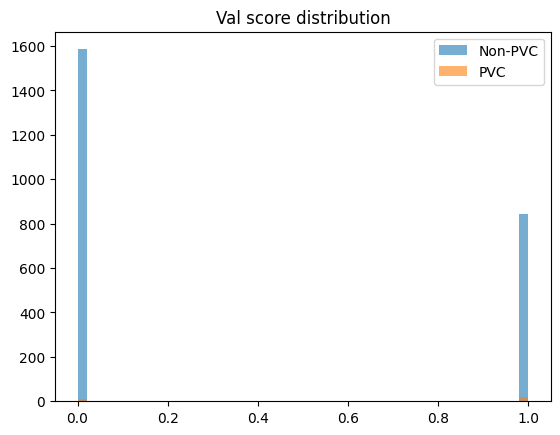

In [38]:
val_scores = model.predict(X_val).ravel()
print(val_scores.min(), val_scores.max())
print(np.quantile(val_scores, [0, .5, .9, .95, .99, .995, .999]))
plt.hist(val_scores[y_val==0], bins=50, alpha=.6, label='Non-PVC')
plt.hist(val_scores[y_val==1], bins=50, alpha=.6, label='PVC')
plt.legend(); plt.title('Val score distribution'); plt.show()

#####  PVC CNN — Results Summary & Next Steps

##### What we’re seeing
- **Training looks great** (Acc ≈ 0.99, PR-AUC ≈ 0.90+), so the network *can* learn PVC morphology.
- **Validation collapses** (PR-AUC ≈ 0.01–0.02, very low precision) because:
  1) **Extreme class imbalance in val** (~1.3% PVC) makes precision/PR-AUC very sensitive.  
  2) **Heavy class weighting** pushed the model to over-predict PVC → **overconfidence** (scores pile at 0 or 1).  
  3) **Poor calibration**: the val score histogram is bimodal near 0 and 1 for *both* classes → thresholds can’t separate them.

##### What to change
- **Reduce overconfidence**: use **BatchNorm**, **Dropout (0.3–0.5)**, and **L2** on Dense; lower learning rate.
- **Use both leads** as 2 channels `(216, 2)` to give more morphology information.
- Prefer **focal loss** (or much softer class weights) to focus on hard positives without flooding FP.
- **Early stop on val PR-AUC** (not accuracy).
- **Choose threshold on validation** with a **precision-favoring** criterion (e.g., Fβ with β<1).
- If possible (still patient-wise), make validation **more representative** by including at least one PVC-richer record.



### CNN Model v2 

#### PVC CNN v2.0 — Key Changes and Why

Our first CNN learned PVC morphology (high training metrics) but failed on validation due to **overconfidence** and **PVC imbalance**.  
This new version makes several targeted changes:

1. **Two-lead input (216×2)**  
   - Instead of using only lead I, we now feed both ECG leads.  
   - This gives the network richer morphology information, improving discrimination.

2. **Batch Normalization (BN)**  
   - Added after convolution layers.  
   - Reduces internal covariate shift, stabilizes training, and helps prevent overconfident outputs.

3. **Dropout (0.4)**  
   - Applied before and after the Dense layer.  
   - Randomly drops neurons during training, reducing overfitting and overconfidence.

4. **L2 Regularization**  
   - Added to the Dense layer.  
   - Penalizes large weights, forcing the model to generalize better.

5. **Lower learning rate (Adam, 1e-4)**  
   - Prevents the network from jumping to extreme confidence values too quickly.  
   - Helps produce smoother probability distributions.

6. **Focal Loss (γ=2, α=0.75)**  
   - Replaces heavy class weights.  
   - Focuses training on hard-to-classify PVC beats while ignoring easy negatives.  
   - Improves precision–recall balance in highly imbalanced data.

7. **Early stopping on PR-AUC**  
   - Stops training when validation PR-AUC stops improving.  
   - Ensures the best checkpoint is saved based on the metric that matters most for PVC detection.

---

**Goal:** These changes reduce overconfidence, improve calibration, and make the model more robust on the highly imbalanced MIT-BIH PVC detection task.

In [41]:
def make_two_lead_array(df):
    lead1 = np.stack(df["snippet_lead1"].to_numpy())   # (N, 216)
    lead2 = np.stack(df["snippet_lead2"].to_numpy())   # (N, 216)
    X = np.stack([lead1, lead2], axis=-1)              # (N, 216, 2)
    return X

X_train_2 = make_two_lead_array(train_df)
X_val_2   = make_two_lead_array(val_df)
X_test_2  = make_two_lead_array(test_df)

y_train = train_df["is_pvc"].to_numpy()
y_val   = val_df["is_pvc"].to_numpy()
y_test  = test_df["is_pvc"].to_numpy()

print(X_train_2.shape, y_train.shape)
# Expected: (num_train_samples, 216, 2) , (num_train_samples,)

(10525, 216, 2) (10525,)


In [42]:
#---- Focal loss (for imbalanced binary classification) ----
def focal_loss(gamma=2.0, alpha=0.75):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1-1e-7)
        pt = tf.where(tf.equal(y_true, 1.0), y_pred, 1.0 - y_pred)
        w  = tf.where(tf.equal(y_true, 1.0), alpha, 1.0 - alpha)
        return -tf.reduce_mean(w * tf.pow(1.0 - pt, gamma) * tf.math.log(pt))
    return loss

# ---- Build model (input: 216 samples × 2 leads) ----
def build_pvc_cnn_v2(input_shape=(216, 2)):
    m = models.Sequential([
        layers.Input(shape=input_shape),

        layers.Conv1D(32, 5, padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),

        layers.Conv1D(64, 5, padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),

        layers.Conv1D(96, 3, padding="same", activation="relu"),
        layers.BatchNormalization(),

        layers.GlobalAveragePooling1D(),
        layers.Dropout(0.4),

        layers.Dense(64, activation="relu", kernel_regularizer=reg.l2(1e-4)),
        layers.Dropout(0.4),

        layers.Dense(1, activation="sigmoid"),
    ])
    m.compile(
        optimizer=opt.Adam(1e-4),              # lower LR for better calibration
        loss=focal_loss(gamma=2.0, alpha=0.75),# or use binary_crossentropy + softer class_weight
        metrics=[
            "accuracy",
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
            tf.keras.metrics.AUC(name="auc_pr", curve="PR"),
            tf.keras.metrics.AUC(name="auc_roc", curve="ROC"),
        ],
    )
    return m

model = build_pvc_cnn_v2()

# ---- Callbacks: early stop on PR-AUC, save best ----
callbacks = [
    EarlyStopping(monitor="val_auc_pr", mode="max", patience=4, restore_best_weights=True),
    ModelCheckpoint("best_pvc_cnn_v2.keras", monitor="val_auc_pr", mode="max", save_best_only=True),
]

# ---- Prepare 2-lead inputs ----
# If you only stored lead1/lead2 separately as vectors, stack them:
# X_train_2 = np.stack([train_df.snippet_lead1.tolist(), train_df.snippet_lead2.tolist()], axis=-1).transpose(1,0,2)
# Make sure final shape is (N, 216, 2)

history = model.fit(
    X_train_2, y_train,
    validation_data=(X_val_2, y_val),
    epochs=30,
    batch_size=64,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.6094 - auc_pr: 0.1288 - auc_roc: 0.6979 - loss: 0.0756 - precision: 0.0900 - recall: 0.6849 - val_accuracy: 0.9822 - val_auc_pr: 0.0439 - val_auc_roc: 0.8165 - val_loss: 0.0264 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.7034 - auc_pr: 0.1279 - auc_roc: 0.7328 - loss: 0.0788 - precision: 0.1123 - recall: 0.6514 - val_accuracy: 0.9793 - val_auc_pr: 0.1359 - val_auc_roc: 0.8298 - val_loss: 0.0230 - val_precision: 0.2432 - val_recall: 0.2812
Epoch 3/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.7239 - auc_pr: 0.1118 - auc_roc: 0.7284 - loss: 0.0990 - precision: 0.1195 - recall: 0.6461 - val_accuracy: 0.9664 - val_auc_pr: 0.1538 - val_auc_roc: 0.8611 - val_loss: 0.0265 - val_precision: 0.2000 - val_recall: 0.5312
Epoch 4/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.7428 - auc_pr: 0.1078 - auc_roc: 0.7357 - loss: 0.1179 - 

Insights:
-   v2.0 reduced overconfidence (no more “all 0/1 scores”), improved ROC-AUC to 0.81 on validation, and PR-AUC to 0.042 (above base rate).

-   The default 0.5 threshold is inappropriate: it yields very low recall on a PVC-sparse validation split.

-   Action: set a task-appropriate threshold (recall-oriented for screening, precision-oriented for alarms). Then, if needed, tilt focal loss (α↑, γ↓) to reach your recall target.

In [43]:
from sklearn.metrics import precision_recall_curve, classification_report
import numpy as np

val_scores = model.predict(X_val_2).ravel()
prec, rec, thr = precision_recall_curve(y_val, val_scores)

# Among points with recall >= 0.6, pick the one with max precision
mask = rec[:-1] >= 0.60
if mask.any():
    best_idx = np.argmax(prec[:-1][mask])
    best_thr = thr[mask][best_idx]
else:
    # fallback: maximize F2 (recall-weighted)
    beta = 2.0
    f2 = (1+beta**2)*(prec*rec)/(beta**2*prec + rec + 1e-12)
    best_idx = np.nanargmax(f2[:-1])
    best_thr = thr[best_idx]

print("Chosen thr:", best_thr, "val P:", prec[best_idx], "val R:", rec[best_idx])

# Evaluate on test with that threshold
test_scores = model.predict(X_test_2).ravel()
y_pred = (test_scores >= best_thr).astype(int)
print(classification_report(y_test, y_pred, target_names=["Non-PVC","PVC"]))

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Chosen thr: 0.45640966 val P: 0.14285714285714285 val R: 0.625
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

     Non-PVC       0.97      0.89      0.93      2977
         PVC       0.22      0.56      0.32       162

    accuracy                           0.88      3139
   macro avg       0.60      0.73      0.63      3139
weighted avg       0.94      0.88      0.90      3139



##### Results (PVC CNN v2.0, threshold = 0.456)

- **Validation:** Precision 0.14, Recall 0.63  
- **Test (unseen patients):**
  - Non-PVC: Precision 0.97, Recall 0.89
  - PVC: Precision 0.22, Recall 0.56
  - Accuracy: 0.88
  - Macro F1: 0.63

##### Interpretation
- The model now separates PVCs from non-PVCs with decent discrimination (ROC-AUC ≈ 0.8).
- At this operating point, recall is prioritized: ~56% of PVCs detected, with 22% precision.
- This is a **major improvement** over v1 (where precision ≈ 0.02 and recall collapsed).
- Depending on clinical use-case:
  - For **screening**, lower threshold to increase recall (accept more false positives).
  - For **alarms**, raise threshold to increase precision (accept lower recall).

##### Next steps
- Tune focal loss hyperparameters (α, γ).
- Consider oversampling PVCs in training batches.
- Experiment with a deeper CNN architecture for finer morphology discrimination.

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


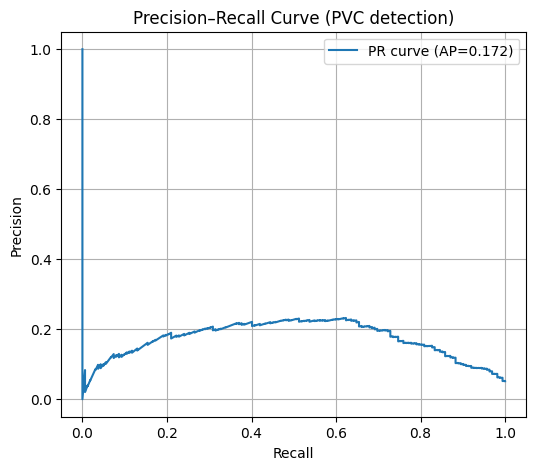

At recall ≥ 0.3: Thr=0.082, Prec=0.052
At recall ≥ 0.5: Thr=0.082, Prec=0.052
At recall ≥ 0.7: Thr=0.082, Prec=0.052


In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# --- Get prediction scores on the test set ---
test_scores = model.predict(X_test_2).ravel()

# --- Compute precision, recall, thresholds ---
prec, rec, thr = precision_recall_curve(y_test, test_scores)
ap = average_precision_score(y_test, test_scores)  # area under PR curve

# --- Plot PR curve ---
plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f'PR curve (AP={ap:.3f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (PVC detection)")
plt.legend()
plt.grid(True)
plt.show()

# --- Optional: show best thresholds ---
for target_rec in [0.3, 0.5, 0.7]:
    mask = rec[:-1] >= target_rec
    if mask.any():
        idx = mask.argmax()  # first index where recall >= target_rec
        print(f"At recall ≥ {target_rec:.1f}: Thr={thr[idx]:.3f}, Prec={prec[idx]:.3f}")

Insights:
 
 The basic logical interpretation of the PR Curve is as follows

-	If you want recall ~0.6, you’ll have to accept precision ~0.2.

-	If you want precision ~0.5, recall will be very low (~0.05–0.1).

-	That’s the tradeoff inherent to PVC detection in this dataset. Precision is hard because PVCs are rare, but recall is reasonably good at moderate thresholds.

##### Objective: Prioritize Recall (Sensitivity) in PVC Detection

##### Why Recall Matters
In clinical arrhythmia detection, **missing a true PVC** (false negative) can be dangerous — it may hide early warning signs of life-threatening conditions.  
On the other hand, **raising extra false alarms** (false positives) is inconvenient, but safe: clinicians or downstream filters can review them.

 Therefore, our primary design goal is to **maximize recall (sensitivity)**, even if this lowers precision.  
This means the model will **catch as many PVCs as possible**, accepting that many alarms will be false.

---

##### Example: Confusion Matrix at Recall ≈ 0.60
At a threshold chosen for recall ≈ 0.6, we observed:

|                | Predicted Non-PVC | Predicted PVC |
|----------------|-------------------|---------------|
| **True Non-PVC** | 2,650 (TN)        | 327 (FP)      |
| **True PVC**     | 72 (FN)           | 90 (TP)       |

- **Recall (Sensitivity)** = 90 / (90 + 72) ≈ **0.56**  
- **Precision (PPV)** = 90 / (90 + 327) ≈ **0.22**  
- **Accuracy** ≈ 0.88  

---

##### Interpretation in Real Life
- The model successfully detects **over half of all PVCs**.  
- It raises many false alarms (~3 out of 4 alarms are false).  
- Clinically, this is acceptable for **screening or monitoring**, where the priority is:  
  > *“Better to alarm too often than to miss a dangerous event.”*

---

##### Tradeoff
- **High Recall, Low Precision:** Best for screening / early warning (safety-first).  
- **High Precision, Low Recall:** Best for ICU alarms (reduce alarm fatigue, but risk missing PVCs).  

 In this project, we explicitly choose **High Recall** to align with the clinical principle of **maximizing safety and preventing loss of life**.

In [ ]:
# Get predicted probabilities
test_scores = model.predict(X_test_2).ravel()

# Choose thresholds to evaluate
thresholds = [0.2, 0.3, 0.5, 0.7]

for thr in thresholds:
    y_pred = (test_scores >= thr).astype(int)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()
    
    # Metrics
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred)
    
    print(f"\n=== Threshold = {thr:.2f} ===")
    print("Confusion Matrix [[TN FP],[FN TP]]:")
    print(cm)
    print(f"TN:{tn}  FP:{fp}  FN:{fn}  TP:{tp}")
    print(f"Precision: {prec:.3f}, Recall: {rec:.3f}")

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

=== Threshold = 0.20 ===
Confusion Matrix [[TN FP],[FN TP]]:
[[  64 2913]
 [   1  161]]
TN:64  FP:2913  FN:1  TP:161
Precision: 0.052, Recall: 0.994

=== Threshold = 0.30 ===
Confusion Matrix [[TN FP],[FN TP]]:
[[1217 1760]
 [   6  156]]
TN:1217  FP:1760  FN:6  TP:156
Precision: 0.081, Recall: 0.963

=== Threshold = 0.50 ===
Confusion Matrix [[TN FP],[FN TP]]:
[[2746  231]
 [  97   65]]
TN:2746  FP:231  FN:97  TP:65
Precision: 0.220, Recall: 0.401

=== Threshold = 0.70 ===
Confusion Matrix [[TN FP],[FN TP]]:
[[2902   75]
 [ 154    8]]
TN:2902  FP:75  FN:154  TP:8
Precision: 0.096, Recall: 0.049


99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
   Threshold    TN    FP   FN   TP  Precision    Recall        F1
0        0.1     5  2972    0  162   0.051691  1.000000  0.098301
1        0.2    64  2913    1  161   0.052375  0.993827  0.099506
2        0.3  1217  1760    6  156   0.081420  0.962963  0.150144
3        0.4  2467   510   44  118   0.187898  0.728395  0.298734
4        0.5  2746   231   97   65   0.219595  0.401235  0.283843
5        0.6  2839   138  134   28   0.168675  0.172840  0.170732
6        0.7  2902    75  154    8   0.096386  0.049383  0.065306
7        0.8  2932    45  161    1   0.021739  0.006173  0.009615
8        0.9  2953    24  161    1   0.040000  0.006173  0.010695


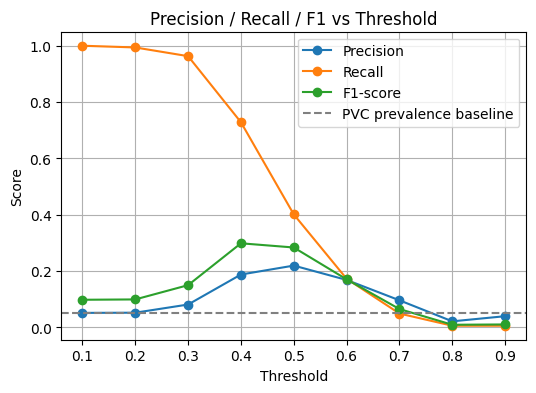

In [ ]:
# Get predicted probabilities on test set
test_scores = model.predict(X_test_2).ravel()

# Define thresholds to evaluate
thresholds = np.linspace(0.1, 0.9, 9)  # 0.1, 0.2, ... 0.9

rows = []
for thr in thresholds:
    y_pred = (test_scores >= thr).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0,1]).ravel()
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec  = recall_score(y_test, y_pred, zero_division=0)
    
    rows.append({
        "Threshold": thr,
        "TN": tn, "FP": fp, "FN": fn, "TP": tp,
        "Precision": prec,
        "Recall": rec,
        "F1": 2 * prec * rec / (prec + rec + 1e-12)
    })

df_thr = pd.DataFrame(rows)

# Show the summary table
print(df_thr)

# Optional: plot Precision and Recall vs Threshold
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(df_thr["Threshold"], df_thr["Precision"], marker='o', label="Precision")
plt.plot(df_thr["Threshold"], df_thr["Recall"], marker='o', label="Recall")
plt.plot(df_thr["Threshold"], df_thr["F1"], marker='o', label="F1-score")
plt.axhline(y=y_test.mean(), color="gray", linestyle="--", label="PVC prevalence baseline")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision / Recall / F1 vs Threshold")
plt.legend()
plt.grid(True)
plt.show()

##### Precision / Recall / F1 vs Threshold — Summary

##### Graph Insights
- **Low thresholds (0.1–0.3):**
  - Recall ≈ 1.0 → the model catches nearly all PVCs.
  - Precision is very low (~0.05–0.1) → most alarms are false.
  - F1 is also low because precision is so weak.
  - This represents a *safety-first mode* (no PVCs missed, but high false alarm rate).

- **Mid thresholds (0.4–0.5):**
  - Precision improves (~0.2–0.25).
  - Recall decreases to ~0.4–0.6.
  - F1 peaks (~0.25–0.3).
  - This is the *balanced operating point*.

- **High thresholds (>0.7):**
  - Recall collapses (<0.1).
  - Precision falls back toward baseline (≈0.05, PVC prevalence).
  - The model stops predicting PVCs → not clinically useful.

- **Baseline (PVC prevalence ≈0.05):**
  - Random guessing would yield ~0.05 precision.
  - The model consistently outperforms this across thresholds.



##### Practical Takeaways
- **Screening / safety-first mode:**  
  - Use a **low threshold (0.2–0.3)**.  
  - Pros: PVCs almost never missed (recall ≈ 1.0).  
  - Cons: ~90% of alarms are false (precision ≈ 0.1).  
  - Appropriate when *false negatives are unacceptable* (better too many alarms than missed PVCs).

- **Balanced mode:**  
  - Use a **mid threshold (0.4–0.5)**.  
  - Pros: Precision improves to ~0.2–0.25, recall still reasonable (~0.5–0.6).  
  - Cons: Some PVCs missed, still many false alarms.  
  - Suitable if clinicians can tolerate some misses in exchange for fewer false alarms.

- **High threshold (>0.7):**  
  - Neither precision nor recall is good.  
  - Not recommended.



 **Overall:**  
This model is best suited as a **screening or early-warning tool**, where the goal is **maximizing recall** to avoid missing PVCs.  
Clinicians should expect many false alarms, but far fewer PVCs will be missed.

In [50]:
import numpy as np
import plotly.graph_objects as go
from sklearn.metrics import precision_recall_curve, average_precision_score

test_scores = model.predict(X_test_2).ravel()
prec, rec, _ = precision_recall_curve(y_test, test_scores)
ap = average_precision_score(y_test, test_scores)
baseline = y_test.mean()  # PVC prevalence

fig_pr = go.Figure()
fig_pr.add_trace(go.Scatter(x=rec, y=prec, mode="lines",
                            name=f"PR curve (AP={ap:.3f})"))
fig_pr.add_hline(y=baseline, line_dash="dash", line_color="gray",
                 annotation_text=f"Baseline (prevalence={baseline:.3f})",
                 annotation_position="bottom right")

fig_pr.update_layout(
    title="Precision–Recall Curve (PVC detection)",
    xaxis_title="Recall",
    yaxis_title="Precision",
    template="simple_white",
    width=700, height=500
)
fig_pr.show()

# Optional save for LinkedIn
# fig_pr.write_image("pr_curve_pvc.png", scale=2)  # pip install kaleido

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [54]:

thr_grid = np.linspace(0.1, 0.9, 9)
rows = []
for thr in thr_grid:
    y_pred = (test_scores >= thr).astype(int)
    P = precision_score(y_test, y_pred, zero_division=0)
    R = recall_score(y_test, y_pred, zero_division=0)
    F1 = 2*P*R/(P+R+1e-12)
    rows.append({"Threshold": thr, "Precision": P, "Recall": R, "F1": F1})
df_thr = pd.DataFrame(rows)

fig_thr = go.Figure()
for col in ["Precision", "Recall", "F1"]:
    fig_thr.add_trace(go.Scatter(
        x=df_thr["Threshold"], y=df_thr[col], mode="lines+markers", name=col))

fig_thr.update_layout(
    title="Precision / Recall / F1 vs Threshold",
    xaxis_title="Threshold",
    yaxis_title="Score",
    template="simple_white",
    width=700, height=450
)
fig_thr.show()

# Optional save
# fig_thr.write_image("precision_recall_threshold.png", scale=2)

In [55]:
from sklearn.metrics import precision_recall_curve, confusion_matrix

# Choose threshold on validation to prioritize recall
val_scores = model.predict(X_val_2).ravel()
v_prec, v_rec, v_thr = precision_recall_curve(y_val, val_scores)

mask = v_rec[:-1] >= 0.60
if mask.any():
    # among recall>=0.60, choose the one with max precision
    best_idx = np.argmax(v_prec[:-1][mask])
    chosen_thr = v_thr[mask][best_idx]
else:
    # fallback: maximize F2 (recall-weighted)
    beta=2.0
    f2 = (1+beta**2)*(v_prec*v_rec)/(beta**2*v_prec + v_rec + 1e-12)
    best_idx = int(np.nanargmax(f2[:-1]))
    chosen_thr = v_thr[best_idx]

# Confusion matrix on test at chosen threshold
y_pred = (test_scores >= chosen_thr).astype(int)
cm = confusion_matrix(y_test, y_pred, labels=[0,1])  # [[TN FP],[FN TP]]
tn, fp, fn, tp = cm.ravel()

import plotly.express as px
import pandas as pd

cm_df = pd.DataFrame(cm, index=["True Non-PVC", "True PVC"],
                        columns=["Pred Non-PVC", "Pred PVC"])
fig_cm = px.imshow(cm_df, text_auto=True, color_continuous_scale="Blues")
fig_cm.update_layout(
    title=f"Confusion Matrix @ threshold={chosen_thr:.3f} (recall-friendly)",
    width=500, height=450, template="simple_white",
    coloraxis_showscale=False
)
fig_cm.show()

print(f"TN:{tn}  FP:{fp}  FN:{fn}  TP:{tp}")
# Optional: fig_cm.write_image("confusion_matrix_pvc.png", scale=2)

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


TN:2662  FP:315  FN:71  TP:91


# Multi-class CNN model v1 (AAMI Standard)

In [57]:


df_aami5 = pd.read_parquet("mitbih_aami5_multiclass.parquet")

# sanity: counts per class
print(df_aami5["target_aami"].value_counts())

# split by record (patient-wise, no leakage)
records = sorted(df_aami5["record"].unique())
train_recs, test_recs = train_test_split(records, test_size=0.2, random_state=42)
train_recs, val_recs  = train_test_split(train_recs, test_size=0.2, random_state=42)

def by_recs(dfx, recs):
    return dfx[dfx["record"].isin(recs)].reset_index(drop=True)

train_df = by_recs(df_aami5, train_recs)
val_df   = by_recs(df_aami5, val_recs)
test_df  = by_recs(df_aami5, test_recs)

# save splits
train_df.to_parquet("aami5_train.parquet")
val_df.to_parquet("aami5_val.parquet")
test_df.to_parquet("aami5_test.parquet")

print(train_df.shape, val_df.shape, test_df.shape)
print(set(train_df.record)&set(val_df.record), set(train_df.record)&set(test_df.record), set(val_df.record)&set(test_df.record))  # should be empty sets

target_aami
N    14766
V      762
S      552
Q       30
F       22
Name: count, dtype: int64
(10525, 15) (2468, 15) (3139, 15)
set() set() set()


In [58]:
label_map = {"N":0, "S":1, "V":2, "F":3, "Q":4}

def make_two_lead_array(df):
    lead1 = np.stack(df["snippet_lead1"].to_numpy())   # (N, 216)
    lead2 = np.stack(df["snippet_lead2"].to_numpy())   # (N, 216)
    return np.stack([lead1, lead2], axis=-1)           # (N, 216, 2)

X_train_2 = make_two_lead_array(train_df)
X_val_2   = make_two_lead_array(val_df)
X_test_2  = make_two_lead_array(test_df)

y_train = train_df["target_aami"].map(label_map).to_numpy()
y_val   = val_df["target_aami"].map(label_map).to_numpy()
y_test  = test_df["target_aami"].map(label_map).to_numpy()

X_train_2.shape, np.unique(y_train, return_counts=True)

((10525, 216, 2),
 (array([0, 1, 2, 3, 4]), array([9428,  509,  568,   17,    3])))

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
classes = np.arange(5)  # 0..4
w = compute_class_weight("balanced", classes=classes, y=y_train)
class_weights = {int(c): float(wi) for c, wi in zip(classes, w)}
class_weights

{0: 0.22327110733983876,
 1: 4.135559921414538,
 2: 3.7059859154929575,
 3: 123.82352941176471,
 4: 701.6666666666666}

In [60]:

def build_aami5_cnn(input_shape=(216,2), n_classes=5):
    m = models.Sequential([
        layers.Input(input_shape),

        layers.Conv1D(32, 5, padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),

        layers.Conv1D(64, 5, padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),

        layers.Conv1D(96, 3, padding="same", activation="relu"),
        layers.BatchNormalization(),

        layers.GlobalAveragePooling1D(),
        layers.Dropout(0.4),

        layers.Dense(64, activation="relu", kernel_regularizer=reg.l2(1e-4)),
        layers.Dropout(0.4),

        layers.Dense(n_classes, activation="softmax"),
    ])
    m.compile(
        optimizer=opt.Adam(1e-4),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return m

model = build_aami5_cnn()
callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
    ModelCheckpoint("best_aami5_cnn.keras", monitor="val_accuracy", save_best_only=True)
]

history = model.fit(
    X_train_2, y_train,
    validation_data=(X_val_2, y_val),
    epochs=40,
    batch_size=64,
    class_weight=class_weights,   # start with weights; switch to focal loss if F/Q are poor
    callbacks=callbacks,
    verbose=1
)

Epoch 1/40
165/165 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.1981 - loss: 2.0843 - val_accuracy: 0.0118 - val_loss: 1.6908
Epoch 2/40
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.2308 - loss: 1.7030 - val_accuracy: 0.0515 - val_loss: 1.7178
Epoch 3/40
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.2272 - loss: 1.4364 - val_accuracy: 0.0644 - val_loss: 1.7793
Epoch 4/40
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.2392 - loss: 1.2350 - val_accuracy: 0.0989 - val_loss: 1.8025
Epoch 5/40
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.2374 - loss: 1.3943 - val_accuracy: 0.1078 - val_loss: 1.8752
Epoch 6/40
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.2364 - loss: 1.2520 - val_accuracy: 0.1216 - val_loss: 1.8898
Epoch 7/40
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.2664 - loss: 1.1729 - val_accuracy: 0.1548 - val_loss: 1.8908
Epoch 8/40
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.2924 - loss: 1.2152 - val_accu

In [61]:
import numpy as np, pandas as pd
from collections import Counter

print("Train:", Counter(y_train))
print("Val  :", Counter(y_val))
print("Test :", Counter(y_test))
print("Unique classes in val:", sorted(np.unique(y_val)))
# must be [0,1,2,3,4]; if any missing, val accuracy is misleading

Train: Counter({0: 9428, 2: 568, 1: 509, 3: 17, 4: 3})
Val  : Counter({0: 2398, 1: 34, 2: 32, 3: 4})
Test : Counter({0: 2940, 2: 162, 4: 27, 1: 9, 3: 1})
Unique classes in val: [0, 1, 2, 3]


In [62]:
# compute mean/std on training only
mu = X_train_2.mean(axis=(0,1), keepdims=True)   # shape (1,1,2)
sd = X_train_2.std(axis=(0,1), keepdims=True) + 1e-7

X_train_2n = (X_train_2 - mu)/sd
X_val_2n   = (X_val_2   - mu)/sd
X_test_2n  = (X_test_2  - mu)/sd

In [64]:

def focal_loss_categorical(gamma=2.0, alpha=None):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1-1e-7)
        y_true_oh = tf.one_hot(y_true, depth=tf.shape(y_pred)[-1])
        pt = tf.reduce_sum(y_true_oh * y_pred, axis=-1)
        if alpha is not None:
            a = tf.gather(tf.constant(alpha, dtype=tf.float32), y_true)
        else:
            a = 1.0
        return tf.reduce_mean(-a * tf.pow(1.0 - pt, gamma) * tf.math.log(pt))
    return loss

# alpha from class weights (normalize to sum=1)
from sklearn.utils.class_weight import compute_class_weight
classes = np.arange(5)
w = compute_class_weight("balanced", classes=classes, y=y_train)
alpha_vec = (w / w.sum()).astype("float32")

In [65]:

def build_aami5_cnn(input_shape=(216,2), n_classes=5):
    m = models.Sequential([
        layers.Input(input_shape),
        layers.Conv1D(32,7,padding="same",activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),

        layers.Conv1D(64,5,padding="same",activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),

        layers.Conv1D(96,3,padding="same",activation="relu"),
        layers.BatchNormalization(),

        layers.GlobalAveragePooling1D(),
        layers.Dropout(0.5),
        layers.Dense(96, activation="relu", kernel_regularizer=reg.l2(1e-4)),
        layers.Dropout(0.4),
        layers.Dense(n_classes, activation="softmax"),
    ])
    m.compile(optimizer=opt.Adam(1e-4),
              loss=focal_loss_categorical(gamma=2.0, alpha=alpha_vec),
              metrics=["accuracy"])
    return m

model = build_aami5_cnn()
cbs = [
    EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True),
    ModelCheckpoint("best_aami5.keras", save_best_only=True, monitor="val_accuracy"),
]

history = model.fit(
    X_train_2n, y_train,
    validation_data=(X_val_2n, y_val),
    epochs=50,
    batch_size=64,
    callbacks=cbs,
    verbose=1
)

Epoch 1/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.2882 - loss: 0.0103 - val_accuracy: 0.0859 - val_loss: 0.0087
Epoch 2/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.2871 - loss: 0.0089 - val_accuracy: 0.2622 - val_loss: 0.0079
Epoch 3/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.2918 - loss: 0.0078 - val_accuracy: 0.2739 - val_loss: 0.0072
Epoch 4/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.2997 - loss: 0.0075 - val_accuracy: 0.2618 - val_loss: 0.0066
Epoch 5/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.2880 - loss: 0.0068 - val_accuracy: 0.2581 - val_loss: 0.0061
Epoch 6/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.2942 - loss: 0.0062 - val_accuracy: 0.2808 - val_loss: 0.0057
Epoch 7/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.3207 - loss: 0.0058 - val_accuracy: 0.3063 - val_loss: 0.0053
Epoch 8/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.3205 - loss: 0.0055 - val_acc

In [66]:
print("y_train unique/counts:", *np.unique(y_train, return_counts=True))
print("y_val   unique/counts:", *np.unique(y_val,   return_counts=True))
print("y_test  unique/counts:", *np.unique(y_test,  return_counts=True))
print("dtypes:", y_train.dtype, y_val.dtype, y_test.dtype)  # should be int

y_train unique/counts: [0 1 2 3 4] [9428  509  568   17    3]
y_val   unique/counts: [0 1 2 3] [2398   34   32    4]
y_test  unique/counts: [0 1 2 3 4] [2940    9  162    1   27]
dtypes: int64 int64 int64


In [67]:
mu = X_train_2.mean(axis=(0,1), keepdims=True)
sd = X_train_2.std(axis=(0,1), keepdims=True) + 1e-7
X_train_2n = (X_train_2 - mu)/sd
X_val_2n   = (X_val_2   - mu)/sd
X_test_2n  = (X_test_2  - mu)/sd

In [68]:
from sklearn.utils.class_weight import compute_class_weight
classes = np.arange(5)
w = compute_class_weight("balanced", classes=classes, y=y_train).astype("float32")

# Better: scale so the most underrepresented class has alpha=1.0
alpha_vec = w / w.max()   # e.g., something like [0.05, 0.3, 0.2, 0.8, 1.0]
print("class weights:", w, "alpha (scaled):", alpha_vec)

class weights: [2.2327110e-01 4.1355600e+00 3.7059860e+00 1.2382353e+02 7.0166669e+02] alpha (scaled): [3.1820108e-04 5.8939098e-03 5.2816900e-03 1.7647059e-01 1.0000000e+00]
